In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as mvn

from stein_thinning.thinning import thin

### Generate a random sample from a bivariate Gaussian

In [2]:
rng = np.random.default_rng(12345)

In [3]:
mean = np.array([0., 0.])
cov = np.array([
    [1., 0.8],
    [0.8, 1.],
])

In [4]:
n = 100_000

In [5]:
sample = mvn.rvs(mean=mean, cov=cov, size=n, random_state=rng)
grad = (np.linalg.inv(cov) @ (mean - sample).T).T

### Apply standard Stein thinning

In [6]:
m = 1_000

In [7]:
idx = thin(sample, grad, m)

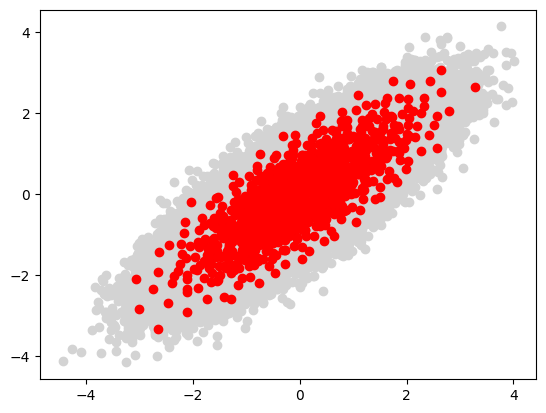

In [8]:
fig, ax = plt.subplots();
ax.scatter(sample[:, 0], sample[:, 1], color='lightgray');
ax.scatter(sample[idx, 0], sample[idx, 1], color='red');

Time the standard Stein thinning implementation

In [9]:
%%timeit
thin(sample, grad, m)

15.9 s ± 91.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Replicate the result of standard Stein thinning using a custom kernel

In [10]:
from stein_thinning.kernel import make_imq
from stein_thinning.thinning import _greedy_search, _validate_and_standardize

In [11]:
s, g = _validate_and_standardize(sample, grad, True)
vfk0 = make_imq(s, 'id')

In [12]:
def integrand(ind1, ind2):
    return vfk0(s[ind1], s[ind2], g[ind1], g[ind2])

In [13]:
idx2 = _greedy_search(m, integrand)

In [14]:
np.testing.assert_array_equal(idx2, idx)

In [15]:
%%timeit
_greedy_search(m, integrand)

15.9 s ± 29.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Check the impact of logging

In [16]:
def _greedy_search_no_log(n_points, integrand):
    # Pre-allocate the index array
    idx = np.empty(n_points, dtype=np.uint32)

    # Array for the running sums
    k0 = integrand(slice(None), slice(None))

    idx[0] = np.argmin(k0)
    #logger.debug('THIN: %d of %d', 1, n_points)
    for i in range(1, n_points):
        k0 += 2 * integrand(slice(None), [idx[i - 1]])
        idx[i] = np.argmin(k0)
        #logger.debug('THIN: %d of %d', i + 1, n_points)

    return idx

In [17]:
%%timeit
_greedy_search_no_log(m, integrand)

16 s ± 200 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Create a JAX-based kernel

In [18]:
import jax
import jax.numpy as jnp

In [19]:
jax.config.update("jax_enable_x64", True)

In [20]:
from stein_thinning.kernel import make_precon

In [21]:
preconditioner = make_precon(s, 'id')

In [22]:
@jax.jit
def vfk0_imq(x, y, sx, sy, linv, c=1.0, beta=-0.5):
    xmy = x.T - y.T
    qf = c + jnp.sum(jnp.dot(linv, xmy) * xmy, axis=0)
    t1 = -4 * beta * (beta - 1) * jnp.sum(jnp.dot(jnp.dot(linv, linv), xmy) * xmy, axis=0) / (qf ** (-beta + 2))
    t2 = -2 * beta * (jnp.trace(linv) + jnp.sum(jnp.dot(linv, sx.T - sy.T) * xmy, axis=0)) / (qf ** (-beta + 1))
    t3 = jnp.sum(sx.T * sy.T, axis=0) / (qf ** (-beta))
    return t1 + t2 + t3

In [23]:
def vfk0_jax(sample1, sample2, gradient1, gradient2):
    return vfk0_imq(jnp.array(sample1), jnp.array(sample2), jnp.array(gradient1), jnp.array(gradient2), jnp.array(preconditioner))

In [24]:
def integrand_jax(ind1, ind2):
    return vfk0_jax(s[ind1], s[ind2], g[ind1], g[ind2])

In [25]:
idx3 = _greedy_search(m, integrand_jax)

Ensure that the resulting indices remain the same:

In [26]:
np.testing.assert_array_equal(idx3, idx)

Time the JAX-based version:

In [27]:
%%timeit
_greedy_search(m, integrand_jax)

10.5 s ± 533 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Create a JAX-based greedy algorithm

In [28]:
from jax.lax import scan

In [29]:
s_jax = jnp.array(s)
g_jax = jnp.array(g)
preconditioner_jax = jnp.array(preconditioner)

In [30]:
def _greedy_search_jax(n_points: int):
    k0 = vfk0_imq(s_jax, s_jax, g_jax, g_jax, preconditioner_jax)
    idx0 = jnp.argmin(k0)
    def body_fun(val, i):
        prev_idx = val[0]
        k0 = val[1] + 2 * vfk0_imq(s_jax, s_jax[prev_idx].reshape(1, -1), g_jax, g_jax[prev_idx].reshape(1, -1), preconditioner_jax)
        selected_idx = jnp.argmin(k0)
        return (selected_idx, k0), selected_idx
    _, idx  = scan(body_fun, (idx0, k0), jnp.arange(1, n_points))
    return np.concatenate([[idx0], idx])

In [31]:
idx4 = _greedy_search_jax(m)

In [32]:
np.testing.assert_array_equal(idx4, idx)

Time this version:

In [33]:
%%timeit
_greedy_search_jax(m)

8.68 s ± 78.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
